# 1. Import libraries

In [1]:
# Import necessary libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import DirectoryIterator

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
# From here, add any libraries that you might need for the rest of your code
# Check if running in Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Mount Google Drive if in Google Colab
if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)  # Mounts Google Drive for each user in Colab
    print("Google Drive mounted successfully in Colab.")

else:
    # If running in a local Jupyter Notebook, ensure the necessary path is set
    print("Running outside Google Colab. Please ensure necessary paths are correctly set in Jupyter Notebook.")


Running outside Google Colab. Please ensure necessary paths are correctly set in Jupyter Notebook.


# 2. Load and pre-process the dataset

In [2]:
# Set the paths based on your Drive directory
data_dir ='D:\T' # Change to the path to your directory

train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: D:\T
Training directory: D:\T\Training
Testing directory: D:\T\Testing


*   This code loads images from directories, adds noise to them, rescales them, and prepares them for training/testing
*   Training data is shuffled and processed in batches of 32 images.
    *   Shuffle for Training: Helps the model generalize by presenting the data in a different order, reducing the risk of model overfitting or learning the order of the data.
    *   No shuffle for Testing: It keeps the test data in the same order, so the evaluation is consistent and reliable.

*   The images are resized to 30x30 pixels, and their pixel values are normalized between 0 and 1.
*   Classes are one-hot encoded, which is important for multi-class classification problems.





In [3]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
# add_noise : To add random Gaussian noise to each image, which can help the model generalize better by preventing it from memorizing training data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30 # resized to 30x30 pixels for processing
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, # Rescales image pixel values from [0,255] to [0,1]
                                 preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=True,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=False,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

*   Visualise random 15 samples from the dataset. Image should be displayed with its corresponding label as text on top of the image.

***The issue with the images not appearing clearly when using this function would be several factors:
     1. Resize to 30x30 pixels
     2. Add_noise function





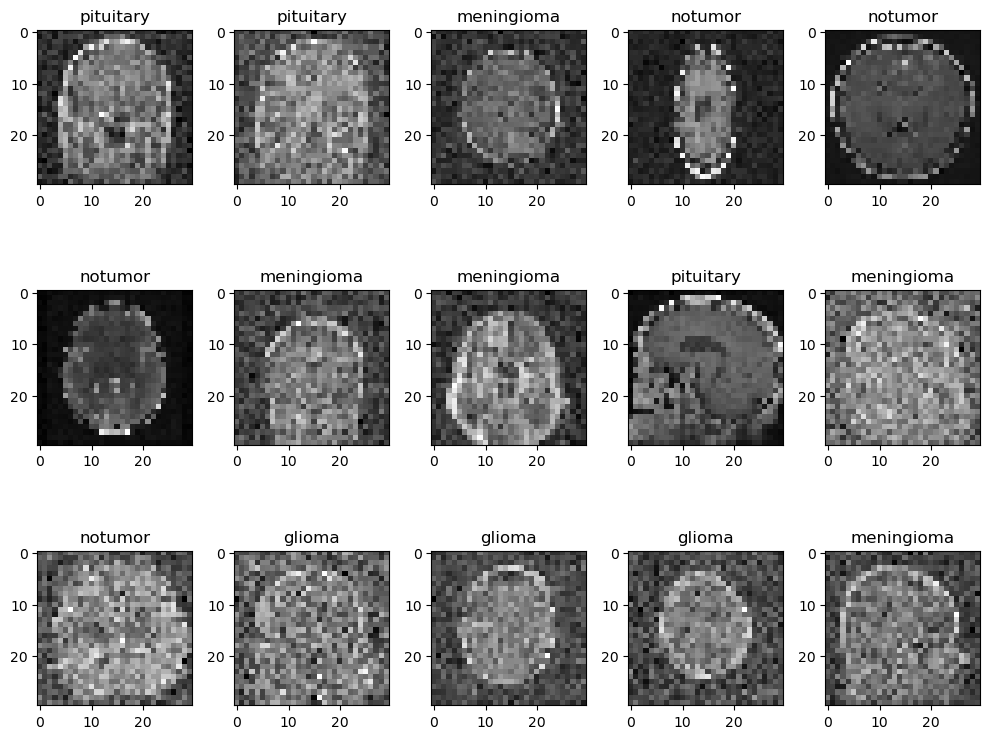

In [4]:
# Function to display 15 random samples from the dataset
def display_random_samples(data_gen, num_samples=15):
    images, labels = next(data_gen)  # Get one batch of images
    indices = random.sample(range(len(images)), num_samples)  # Randomly select 15 images

    plt.figure(figsize=(10, 8))
    for i, idx in enumerate(indices):
        plt.subplot(3, 5, i+1)  # Arrange in a grid 3x5
        img = images[idx].squeeze()  # Squeeze to remove any singleton dimensions (if grayscale)
        plt.imshow(img, cmap='gray')  # Assuming grayscale
        label_idx = np.argmax(labels[idx])  # Get the class label index
        class_label = [k for k, v in train_data.class_indices.items() if v == label_idx][0]
        plt.title(class_label)
    plt.tight_layout()
    plt.show()

# Call the function to display 15 random samples from the training data
display_random_samples(train_data)

*   Create a bar plot to visulaize the class label distribution of the dataset




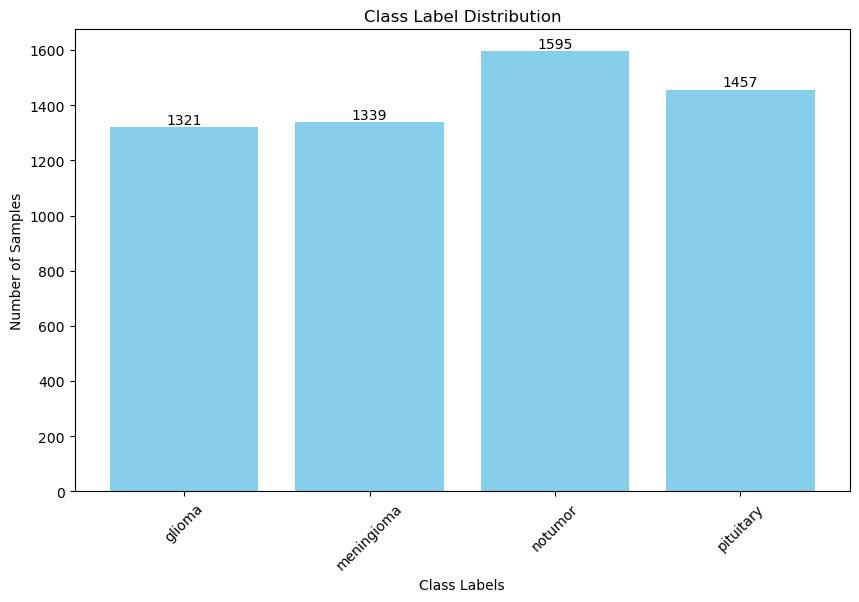

In [5]:
# Create a bar plot to visualize the class label distribution
def plot_class_distribution(data_gen):
    class_labels = list(data_gen.class_indices.keys())  # Get class labels
    num_samples = list(data_gen.classes)  # List of classes for all samples
    class_count = np.bincount(num_samples)  # Count of each class

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_labels, class_count, color='skyblue')

    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title('Class Label Distribution')
    plt.xticks(rotation=45)

    # Add the total number on top of each bar
    for bar, count in zip(bars, class_count):
        yval = bar.get_height()  # Height of the bar (number of samples)
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(count)}', ha='center', va='bottom')

    plt.show()

# Call the function to create the class distribution plot
plot_class_distribution(train_data)


# 4. Train and Evaluation functions

*   Implement the baseline CNN algorithm without any modification for both model and dataset.

  1.   Convolutional layer with 32 filters and kernel size of 3 x 3 with ReLU activations followed by a max pooling layer of size 2 x 2
  2.   Convolutional layer with 32 filters and kernel size of 3 x 3 with ReLu activations followed by a max pooling layer of size 2 x 2
  3.   Flatten the 3D output
  4.   Desn layers of sizes 32 and with Relu activation
  5.   Output layer with softmax activation are added for multi-class classification
  6. The optimizer should be Adam, metric should be acrruracy. The categorical crossentropy loss function is used for multi-class classification problems.







In [6]:
# CNN to classify grayscale images (30x30pixels) into different categories.
# Correct input shape for grayscale images (30x30 pixels, 1 channel)
img_shape = (30, 30, 1)  # 30x30 pixels, 1 channel (grayscale)
model = models.Sequential()

# first convolutional layer + max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = img_shape)) #relu helps to introduce non-linearity
model.add(layers.MaxPooling2D((2,2)))

# second convolutional layer + max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten the 3D output from the convolutional layers into 1D
model.add(layers.Flatten())

# Dense layer with 32 units and ReLU activation
model.add(layers.Dense(32, activation = 'relu'))

num_classes = len(list(train_data.class_indices.keys()))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])

# Summary of the model
model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,596 (182.02 KB)

 Trainable params: 46,596 (182.02 KB)

 Non-trainable params: 0 (0.00 B)

*   Analyze the performance of the baseline by plotting
  1.   **Split the training data and validation data again due to the restriction of not modifying the preprocessing code.**
      
      -> Given that it's not allowed to modify the original preprocessing code and it's already loaded train_data and test_data using the ImageDataGenerator, we need a solution that follows the rule but still allows you to create a validation set from the training data.

      Since we're using ImageDataGenerator to load both the training and test data, the easiest way to create a validation set without modifying the original code is to split the training data after loading it.
  2.   The training and validation losses and accuracies on the training and validation set through epochs
  3.   The Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score and a confusion matrix for the validation and test sets.
  4.   Report performance measures (accuracy, precision, recall, and F1-score) for both validation and test sets.






In [7]:
# Collect all images and labels from the train_data generator
x_data = []
y_data = []

# Loop through the generator to collect data
for i in range(len(train_data)):
    images, labels = next(train_data)
    x_data.extend(images)
    y_data.extend(labels)

# Convert lists to NumPy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Now you can use x_train, y_train for training and x_val, y_val for validation.
print("Split the training and validation data successfully.")
print(f"Number of training samples: {len(x_train)}")  # Should show 80% of total
print(f"Number of validation samples: {len(x_val)}")  # Should show 20% of total
print(f"Number of validation samples: {test_data.samples}")


Split the training and validation data successfully.
Number of training samples: 4569
Number of validation samples: 1143
Number of validation samples: 1311


In [8]:
validation_data=(x_val, y_val)

In [9]:
# Train the model with NumPy arrays
history = model.fit(
    x_train,  # Training data (images)
    y_train,  # Training data (labels)
    validation_data=(x_val, y_val),  # Validation data (images and labels)
    epochs=10,
    shuffle=True
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3695 - loss: 1.2574 - val_accuracy: 0.6640 - val_loss: 0.8446
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6925 - loss: 0.8133 - val_accuracy: 0.7113 - val_loss: 0.6895
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7347 - loss: 0.6886 - val_accuracy: 0.7612 - val_loss: 0.6233
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7715 - loss: 0.6131 - val_accuracy: 0.7612 - val_loss: 0.6216
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7869 - loss: 0.5717 - val_accuracy: 0.7673 - val_loss: 0.5739
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7888 - loss: 0.5530 - val_accuracy: 0.7524 - val_loss: 0.6154
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7998 - loss: 0.5360 - val_accuracy: 0.7822 - val_loss: 0.5568
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8258 - loss: 0.4681 - val_accuracy: 0.

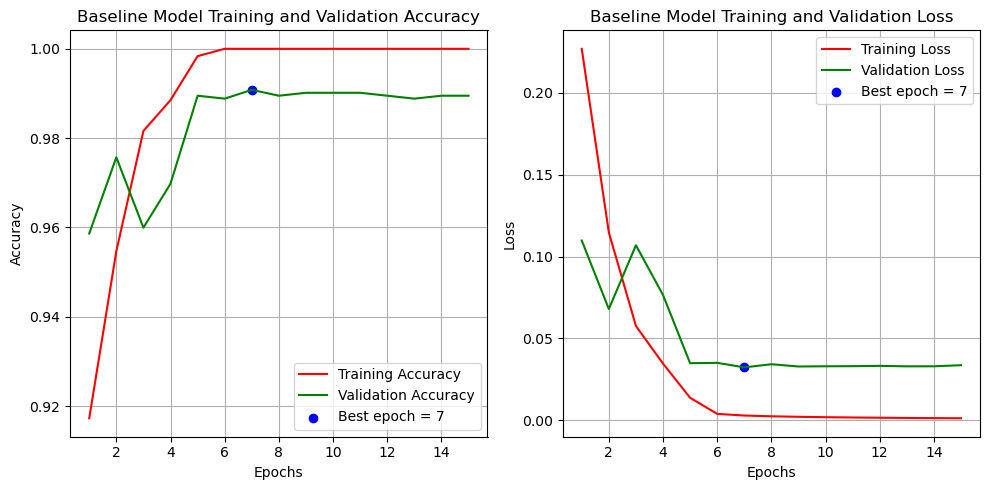

In [45]:
# Assuming 'history' is the variable that holds the result of model.fit()
np.random.seed(42)

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'g', label='Validation Accuracy')
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation accuracy
    best_epoch_acc = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
    plt.scatter(best_epoch_acc, max(history.history['val_accuracy']), label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'g', label='Validation Loss')
    plt.title('Baseline Model Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation loss based on the best validation accuracy epoch
    plt.scatter(best_epoch_acc, history.history['val_loss'][best_epoch_acc - 1], label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the history object returned from model.fit()
plot_training_history(history)

In [11]:
# Create a tensorFlow Dataset for your validation data
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(32)  # Set batch size to match other data generators


In [12]:
def plot_multiclass_roc_and_confusion_matrix(model, data_gen, class_names, set_type='Validation'):
    y_true = []
    y_pred = []

    # Check if data_gen is a TensorFlow Dataset object or a generator
    if isinstance(data_gen, tf.data.Dataset):
        # Collect true labels and predicted probabilities from Dataset
        for images, labels in data_gen:
            preds = model.predict(images)
            y_true.extend(np.argmax(labels, axis=1))
            y_pred.extend(preds)
    else:
        # Collect true labels and predicted probabilities from generator
        for images, labels in data_gen:
            preds = model.predict(images)
            y_true.extend(np.argmax(labels, axis=1))
            y_pred.extend(preds)
            if len(y_true) >= data_gen.samples:
                break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Binarize the output for ROC calculations
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])
    n_classes = y_true_binarized.shape[1]

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC and Confusion Matrix
    plt.figure(figsize=(10, 5))

    # Plot ROC curve
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {set_type} Set')
    plt.legend(loc="lower right")

    # Plot Confusion Matrix
    plt.subplot(1, 2, 2)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {set_type} Set')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━

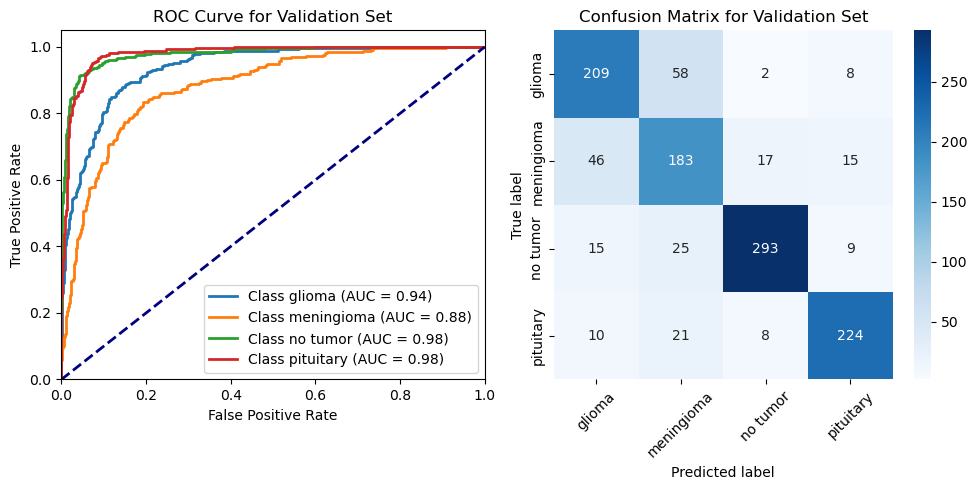

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━

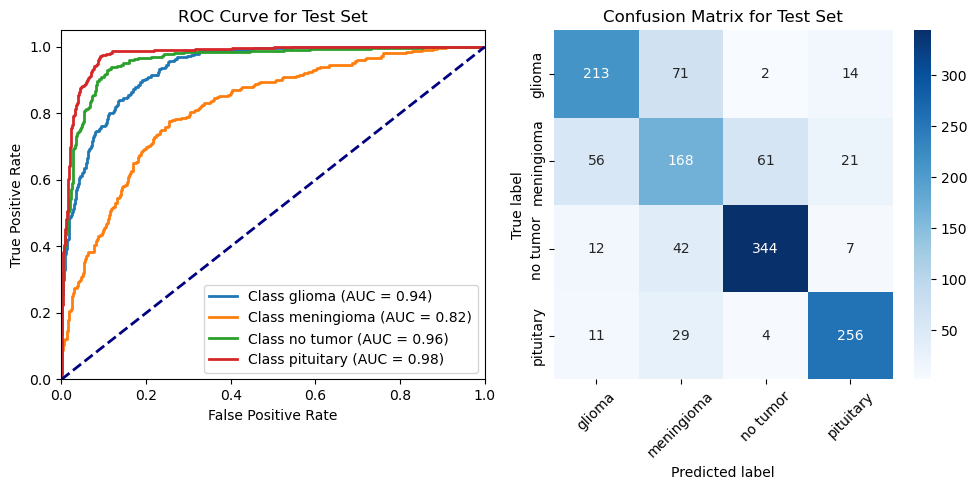

In [13]:
# Define the class names corresponding to your data
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']


# Example usage for the validation set using the custom Dataset
plot_multiclass_roc_and_confusion_matrix(model, val_dataset, class_names, set_type='Validation')

# Example usage for the test set using the DirectoryIterator
plot_multiclass_roc_and_confusion_matrix(model, test_data, class_names, set_type='Test')


# 6. Model Optimization

## 6.1 Get insight from Loops of parameters

### 6.1.1 Define functions that creates models with varying configurations 

Here we add the optimization phase with the hyperparameters mentioned below to the baseline model:
- Filter size
- Number of filters
- Number of layers
- Number of units in dense layers
- Hidden layer activation function
- Padding
- Stride
- Epochs
- Batch size
- Optimizers (Adagrad, RMSprop, Adam, SGD, SGD(momentum=0.9))
- Batch normalization
- L1, L2 regularization (with adjustable lambda)
- Dropout on fully connected layers
- Early Stopping

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adagrad, RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

# Function to create the model with configurable parameters
from tensorflow.keras.regularizers import l1, l2, l1_l2

def create_model(filter_size=(3, 3), num_filters=32, num_layers=2, num_units=64,
                 activation='relu', padding='same', stride=(1, 1), 
                 l1_lambda=0.0, l2_lambda=0.0,dropout_rate=0.0, input_shape=(30, 30, 1), num_classes=4):
    
    
    model = Sequential()
    
    # Determine the regularizer
    if l1_lambda > 0 and l2_lambda > 0:
        regularizer = l1_l2(l1=l1_lambda, l2=l2_lambda)
    elif l1_lambda > 0:
        regularizer = l1(l1_lambda)
    elif l2_lambda > 0:
        regularizer = l2(l2_lambda)
    else:
        regularizer = None

    # Adding convolutional layers
    for i in range(num_layers):
        model.add(Conv2D(filters=num_filters, kernel_size=filter_size, activation=activation,
                         padding=padding, strides=stride, input_shape=input_shape if i == 0 else None,
                         kernel_regularizer=regularizer))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(BatchNormalization())

    # Flatten and add Dense layers
    model.add(Flatten())
    model.add(Dense(num_units, activation=activation, kernel_regularizer=regularizer))
    model.add(Dense(num_units, activation=activation, kernel_regularizer=regularizer))
    model.add(Dropout(dropout_rate))
    
    # Output layer (assuming 10 classes)
    model.add(Dense(num_classes, activation='softmax'))
    
    return model



In [36]:
def train_and_evaluate(filter_size, num_filters, num_layers, num_units, activation, padding, stride, 
                       optimizer_name, l1_lambda, l2_lambda, dropout_rate, epochs, batch_size, num_classes):
    
  
    # Create the model
    model = create_model(filter_size=filter_size, num_filters=num_filters, num_layers=num_layers, 
                         num_units=num_units, activation=activation, padding=padding, stride=stride, 
                         l1_lambda=l1_lambda, l2_lambda=l2_lambda, dropout_rate=dropout_rate, num_classes=num_classes)
    
 
    # Instantiate a new optimizer for each training run
    if optimizer_name == 'adagrad':
        optimizer = Adagrad()
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_name == 'adam':
        optimizer = Adam()
    elif optimizer_name == 'sgd':
        optimizer = SGD() 
    elif optimizer_name == 'sgd_momentum 0.9':
        optimizer = SGD(momentum=0.9)
    elif optimizer_name == 'sgd_momentum 0.8':
        optimizer = SGD(momentum=0.8)
    
    # Compile the model with the selected optimizer
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Using early stopping
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(train_data, validation_data=validation_data, epochs=epochs, 
                        batch_size=batch_size) #, callbacks=[early_stopping]
    
    return history.history


Here we are defining experiments with different settings (Combination of parameters).

This code performs a grid search over the specified parameter space using simple loops.
We can adjust the search space by modifying the lists provided for each hyperparameter.

In [38]:
# Define the ranges of parameters to be tested
filter_sizes = [(3, 3),(5,5)]
num_filters_list = [32, 64]
num_layers_list = [2] 
num_units_list = [32 , 64]
activations = ['relu', 'tanh']
paddings = ['valid','same']
strides = [(1,1), (2, 2)]
epochs_list = [20]
batch_sizes = [16,32]
optimizers = {'rmsprop': RMSprop(), 'adagrad': Adagrad(), 'adam':Adam(), 'sgd':SGD() , 'sgd_momentum 0.9': SGD(momentum=0.9), 'sgd_momentum 0.8': SGD(momentum=0.8)}
l1_lambdas = [0.01 , 0.02]
l2_lambdas = [0.01 , 0.02] 
dropout_rates = [0.0 , 0.2 , 0.5]

# batch normalization
# Early stoping

results = []

# Iterate over all combinations
for filter_size in filter_sizes:
    for num_filters in num_filters_list:
        for num_layers in num_layers_list:
            for num_units in num_units_list:
                for activation in activations:
                    for padding in paddings:
                        for stride in strides:
                            for opt_name in optimizers.keys():  # Use keys instead of values
                                for l1_lambda in l1_lambdas:
                                    for l2_lambda in l2_lambdas:
                                        for dropout_rate in dropout_rates:
                                            for epochs in epochs_list:
                                                for batch_size in batch_sizes:
                                                    print(f"Training model with config: filter_size={filter_size}, num_filters={num_filters}, "
                                                          f"num_layers={num_layers}, num_units={num_units}, activation={activation}, padding={padding}, "
                                                          f"stride={stride}, optimizer={opt_name}, l1_lambda={l1_lambda}, l2_lambda={l2_lambda}, "
                                                          f"dropout_rate={dropout_rate}, epochs={epochs}, batch_size={batch_size}")
                                                    
                                                    # Train and evaluate the model
                                                    history = train_and_evaluate(filter_size, num_filters, num_layers, num_units, activation, 
                                                                                 padding, stride, opt_name, l1_lambda, l2_lambda, dropout_rate, 
                                                                                 epochs, batch_size, num_classes)
                                                    
                                                    # Store the results
                                                    result = {
                                                        'filter_size': filter_size,
                                                        'num_filters': num_filters,
                                                        'num_layers': num_layers,
                                                        'num_units': num_units,
                                                        'activation': activation,
                                                        'padding': padding,
                                                        'stride': stride,
                                                        'optimizer': opt_name,
                                                        'l1_lambda': l1_lambda,
                                                        'l2_lambda': l2_lambda,
                                                        'dropout_rate': dropout_rate,
                                                        'epochs': epochs,
                                                        'batch_size': batch_size,
                                                        'history': history
                                                    }
                                                    results.append(result)

Training model with config: filter_size=(3, 3), num_filters=64, num_layers=2, num_units=32, activation=relu, padding=valid, stride=(1, 1), optimizer=rmsprop, l1_lambda=0.0, l2_lambda=0.0, dropout_rate=0.0, epochs=15, batch_size=32
Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.3929 - loss: 1.2270 - val_accuracy: 0.6010 - val_loss: 0.9573
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.6865 - loss: 0.8043 - val_accuracy: 0.7183 - val_loss: 0.7233
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.7491 - loss: 0.6588 - val_accuracy: 0.7962 - val_loss: 0.5163
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.7654 - loss: 0.5915 - val_accuracy: 0.7988 - val_loss: 0.5168
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.7898 - loss: 0.5375 - val_accuracy: 0.8093 - val_loss: 0.4804
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.8117 - loss: 0.5034 - val_accuracy: 0.8075 - val_lo

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.3683 - loss: 1.2732 - val_accuracy: 0.6194 - val_loss: 0.9327
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.6447 - loss: 0.9003 - val_accuracy: 0.6719 - val_loss: 0.8477
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.6799 - loss: 0.8492 - val_accuracy: 0.7122 - val_loss: 0.7733
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.6860 - loss: 0.8077 - val_accuracy: 0.6842 - val_loss: 0.7734
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.7040 - loss: 0.7709 - val_accuracy: 0.7262 - val_loss: 0.7254
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.7282 - loss: 0.7189 - val_accuracy: 0.7139 - val_loss: 0.7478
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.7273 - loss: 0.7149 - val_accuracy: 0.7200 - val_loss: 0.7332
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.7286 - loss: 0.6975 - 

179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.4405 - loss: 1.1726 - val_accuracy: 0.6675 - val_loss: 0.8344
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.7103 - loss: 0.7477 - val_accuracy: 0.7594 - val_loss: 0.6010
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7774 - loss: 0.5708 - val_accuracy: 0.8241 - val_loss: 0.4700
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.7835 - loss: 0.5382 - val_accuracy: 0.7970 - val_loss: 0.5052
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.8073 - loss: 0.4874 - val_accuracy: 0.8163 - val_loss: 0.4495
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.8127 - loss: 0.4701 - val_accuracy: 0.8119 - val_loss: 0.4844
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.8285 - loss: 0.4316 - val_accuracy: 0.8548 - val_loss: 0.3834
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.8411 - loss: 0.4124 - val_acc

179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.3974 - loss: 1.2440 - val_accuracy: 0.5416 - val_loss: 1.0512
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.6625 - loss: 0.8706 - val_accuracy: 0.6579 - val_loss: 0.8667
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.6971 - loss: 0.8080 - val_accuracy: 0.7043 - val_loss: 0.7714
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.7034 - loss: 0.7758 - val_accuracy: 0.7165 - val_loss: 0.7363
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.7297 - loss: 0.7016 - val_accuracy: 0.6850 - val_loss: 0.8149
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.7256 - loss: 0.6958 - val_accuracy: 0.7428 - val_loss: 0.6759
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.7408 - loss: 0.6629 - val_accuracy: 0.7647 - val_loss: 0.6229
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.7483 - loss: 0.6464 - val_accurac

### 6.1.2 Visualizing the Results of varying configurations

To visually compare the results from the different configurations, We provided code to generate graphs for the key metrics ( training accuracy, validation accuracy). This will help to evaluate the impact of various hyperparameters on model performance.

In [39]:
import pickle

# Update the path to a location on your local machine
save_path = 'model_comparison_results.pkl'  # Saves in the current working directory

# Save the results to a file for later analysis
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

# Replace 'your_results_file.pkl' with the path to your pickle file
with open('model_comparison_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [40]:
import pandas as pd

# Create a DataFrame from the loaded results
records = []
for result in results:
    record = {
        'filter_size': result['filter_size'],
        'num_filters': result['num_filters'],
        'num_layers': result['num_layers'],
        'num_units': result['num_units'],
        'activation': result['activation'],
        'padding': result['padding'],
        'stride': result['stride'],
        'optimizer': result['optimizer'],
        'l1_lambda': result['l1_lambda'],
        'l2_lambda': result['l2_lambda'],
        'dropout_rate': result['dropout_rate'],
        'epochs': result['epochs'],
        'batch_size': result['batch_size'],
        'train_accuracy': max(result['history']['accuracy']),
        'val_accuracy': max(result['history']['val_accuracy']),
        'train_loss': min(result['history']['loss']),
        'val_loss': min(result['history']['val_loss']),
    }
    records.append(record)

results_df = pd.DataFrame(records)


In [51]:
import plotly.express as px

# Create an interactive scatter plot for training vs validation accuracy
fig = px.scatter(
    results_df, 
    x='train_accuracy', 
    y='val_accuracy', 
    color='optimizer',  # Color by optimizer to differentiate
    hover_data=['filter_size', 'num_filters', 'num_layers', 'num_units', 
                'activation', 'padding', 'stride', 'l1_lambda', 'l2_lambda', 
                'dropout_rate', 'epochs', 'batch_size'],  # Display parameter details
    title='Training vs Validation Accuracy for Different Optimizers',
    labels={'train_accuracy': 'Training Accuracy', 'val_accuracy': 'Validation Accuracy'},
    size='train_accuracy',  # Change the size based on a column, you can replace with any column in your data,
    size_max=10,  # Adjust this value to make bubbles larger or smaller (default is 20)
)

fig.show()


## 6.2 Use the insight from the last part to create the best model

In [42]:
# CNN to classify grayscale images (30x30pixels) into different categories.
# Correct input shape for grayscale images (30x30 pixels, 1 channel)
img_shape = (30, 30, 1)

# 30x30 pixels, 1 channel (grayscale)
model_9 = models.Sequential()

# first convolutional layer 
model_9.add(layers.Conv2D(64, (3, 3), activation = 'tanh', input_shape = img_shape,padding='same',strides=(1,1))) #relu helps to introduce non-linearity


# second convolutional layer + max pooling layer
model_9.add(layers.Conv2D(64, (3, 3), activation = 'tanh',padding='same',strides=(1,1)))
model_9.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# third convolutional layer + max pooling layer
model_9.add(layers.Conv2D(32, (3, 3), activation = 'tanh',padding='valid',strides=(1,1)))
model_9.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))



# flatten the 3D output from the convolutional layers into 1D
model_9.add(layers.Flatten())

# Dense layer with 32 units and ReLU activation
model_9.add(layers.Dense(32, activation = 'tanh'))
model_9.add(layers.Dense(32, activation = 'tanh'))

num_classes = len(list(train_data.class_indices.keys()))
model_9.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model_9.compile(optimizer=SGD(momentum=0.8),
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])

# Summary of the model
model_9.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 30, 30, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 30, 30, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 13, 13, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 32)                  │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,116 (367.64 KB)

 Trainable params: 94,116 (367.64 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:

from sklearn.model_selection import KFold


# Set seeds
np.random.seed(42)

# Prepare k-fold cross-validation
k = 3  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to hold metrics for each fold
train_histories_9 = []

# K-fold cross-validation
for train_index, val_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model on the current fold
    history = model_9.fit(
        x_train_fold, 
        y_train_fold,  
        validation_data=(x_val_fold, y_val_fold),  
        epochs=15,
        shuffle=True,
        batch_size=16
    )

    train_histories_9.append(history.history)

# After training, you can average the metrics across folds if needed
# For example:
average_accuracy = np.mean([h['val_accuracy'] for h in train_histories_9], axis=0)
average_loss = np.mean([h['val_loss'] for h in train_histories_9], axis=0)

print("Training completed across {} folds.".format(k))


Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.4652 - loss: 1.1593 - val_accuracy: 0.6796 - val_loss: 0.7991
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7136 - loss: 0.7650 - val_accuracy: 0.7367 - val_loss: 0.6932
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7394 - loss: 0.6465 - val_accuracy: 0.7571 - val_loss: 0.5989
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8002 - loss: 0.5124 - val_accuracy: 0.7682 - val_loss: 0.5923
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8260 - loss: 0.4748 - val_accuracy: 0.7374 - val_loss: 0.6486
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8429 - loss: 0.4163 - val_accuracy: 0.7932 - val_loss: 0.5283
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8692 - loss: 0.3523 - val_accuracy: 0.7814 - val_loss: 0.5888
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8897 - loss: 0.2901 - val_

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_history(train_histories):
    """
    Plots the average training and validation loss and accuracy.

    Parameters:
    train_histories (list): List of training history dictionaries from each fold.
    """
    # Number of folds
    k = len(train_histories)

    # Initialize arrays to store the average metrics
    avg_train_loss = np.mean([h['loss'] for h in train_histories], axis=0)
    avg_val_loss = np.mean([h['val_loss'] for h in train_histories], axis=0)

    avg_train_accuracy = np.mean([h['accuracy'] for h in train_histories], axis=0)
    avg_val_accuracy = np.mean([h['val_accuracy'] for h in train_histories], axis=0)

    # Number of epochs
    epochs = len(avg_train_loss)

    # Plotting Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), avg_train_loss, label='Training Loss', color='blue')
    plt.plot(range(1, epochs + 1), avg_val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), avg_train_accuracy, label='Training Accuracy', color='blue')
    plt.plot(range(1, epochs + 1), avg_val_accuracy, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Show plots
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_training_history(train_histories)



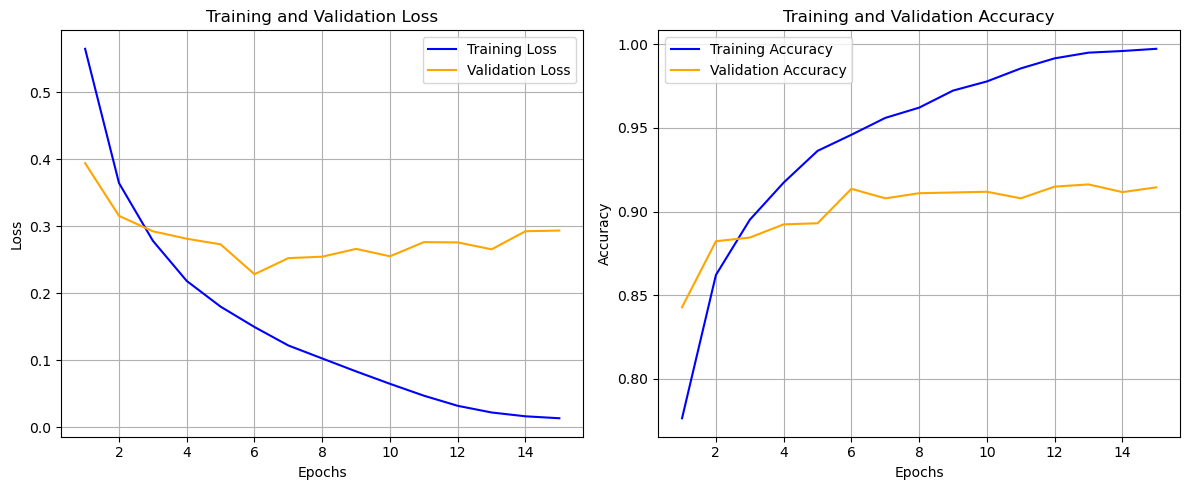

In [49]:
plot_training_history(train_histories_9)

## 6.3 Apply the model on test set

# 7. Transfer Learning